<a href="https://colab.research.google.com/github/lekiho/NSR_AD/blob/main/GTA_wadi_swat_hai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
my_path = '/content/notebooks'

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/GTA/myenv')
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/GTA')

In [ ]:
print(sys.path)

['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/Colab_Notebooks/GTA/myenv', '/content/drive/MyDrive/Colab_Notebooks/GTA']


In [ ]:
# !pip install --target=$my_path -r /content/drive/MyDrive/'Colab Notebooks'/GTA/requirements.txt

In [ ]:
def down_cast(df, columns) :
    df_list = []
    for column in columns :
        try:
            df[column] = pd.to_numeric(df[column], downcast='integer')
        except:
            pass
        try:
            df[column] = pd.to_numeric(df[column], downcast='float')
        except:
            pass
        try:
            df[column] = pd.to_object(df[column], downcast='object')
        except:
            pass
        df_list.append(df[column])
    return pd.concat(df_list, axis=1)

In [ ]:
import os

import pandas as pd
import numpy as np
#downsampling
from myenv import process_wadi
import re
from sklearn.preprocessing import MinMaxScaler

In [ ]:
dirpath = os.getcwd()
x_train = pd.read_csv(os.path.join(dirpath, 'data', '/content/drive/MyDrive/Colab_Notebooks/GTA/data/WADI.A2_19_Nov_2019/WADI_14days_new.csv'), index_col=[0])

In [ ]:
x_test = pd.read_csv(os.path.join(dirpath, 'data', '/content/drive/MyDrive/Colab_Notebooks/GTA/data/WADI.A2_19_Nov_2019/WADI_attackdataLABLE.csv'), index_col=[0])

In [ ]:
down_cast(x_train, x_train.columns)
down_cast(x_test, x_test.columns)

In [ ]:
x_test['Attack LABLE (1:No Attack, -1:Attack)'] = (x_test['Attack LABLE (1:No Attack, -1:Attack)'] -1)*((-1)/2)
x_test['attack'] = x_test['Attack LABLE (1:No Attack, -1:Attack)'].astype(int)
y_test = x_test['attack']
x_test.drop('Attack LABLE (1:No Attack, -1:Attack)', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [ ]:
# x_train.to_csv('/content/drive/MyDrive/Colab Notebooks/GTA/data/WADI.A2_19_Nov_2019/WADI_14days_train.csv')
# x_test.to_csv('/content/drive/MyDrive/Colab Notebooks/GTA/data/WADI.A2_19_Nov_2019/WADI_attackdata_labelled_test.csv')

##### process_wadi

In [ ]:
# max min(0-1)
def norm(train, test):

    normalizer = MinMaxScaler(feature_range=(0, 1)).fit(train) # scale training data to [0,1] range
    train_ret = normalizer.transform(train)
    test_ret = normalizer.transform(test)

    return train_ret, test_ret

In [ ]:
# downsample by 10
def downsample(data, labels, down_len):
    np_data = np.array(data)
    np_labels = np.array(labels)

    orig_len, col_num = np_data.shape

    down_time_len = orig_len // down_len

    np_data = np_data.transpose()
    # print('before downsample', np_data.shape)

    d_data = np_data[:, :down_time_len*down_len].reshape(col_num, -1, down_len)
    d_data = np.median(d_data, axis=2).reshape(col_num, -1)

    d_labels = np_labels[:down_time_len*down_len].reshape(-1, down_len)
    # if exist anomalies, then this sample is abnormal
    d_labels = np.round(np.max(d_labels, axis=1))

    d_data = d_data.transpose()

    # print('after downsample', d_data.shape, d_labels.shape)

    return d_data.tolist(), d_labels.tolist()

In [ ]:
train = x_train
test = x_test

train = train.iloc[:, 2:]
test = test.iloc[:, 2:]


train = train.fillna(train.mean())
test = test.fillna(test.mean())
train = train.fillna(0)
test = test.fillna(0)

# trim column names
train = train.rename(columns=lambda x: x.strip())
test = test.rename(columns=lambda x: x.strip())


train_labels = np.zeros(len(train))
test_labels = test.attack

# train = train.drop(columns=['attack'])
test = test.drop(columns=['attack'])

cols = [x[46:] for x in train.columns] # remove column name prefixes
train.columns = cols
cols = [x[46:] for x in test.columns] # remove column name prefixes
test.columns = cols


x_train1, x_test1 = norm(train.values, test.values)

train = pd.DataFrame(x_train1)
test = pd.DataFrame(x_test1)

# for i, col in enumerate(train.columns):
#     train.loc[:, col] = x_train1[:, i]
#     test.loc[:, col] = x_test1[:, i]

d_train_x, d_train_labels = downsample(train.values, train_labels, 10)
d_test_x, d_test_labels = downsample(test.values, test_labels, 10)

train_df = pd.DataFrame(d_train_x, columns = train.columns)
test_df = pd.DataFrame(d_test_x, columns = test.columns)


test_df['attack'] = d_test_labels
train_df['attack'] = d_train_labels

# train_df = train_df.iloc[2160:]

In [ ]:
train_df.to_csv('/content/drive/MyDrive/Colab_Notebooks/GTA/data/WADI.A2_19_Nov_2019/WADI_14days_downsampled.csv')

##### GTA

In [39]:
# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 7.9 MB 15.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 3.5 MB 14.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 2.5 MB 14.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 750 kB 14.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.d

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
my_path = '/content/notebooks'
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/GTA/myenv')
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/GTA')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ! pip install --target=$my_path -r /content/drive/MyDrive/Colab_Notebooks/GTA/requirements.txt

In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks/GTA
import myenv
# from exp import exp_gta_dad
# from models import gta

/content/drive/MyDrive/Colab_Notebooks/GTA


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
x_train = pd.read_csv(os.path.join('data', '/content/drive/MyDrive/Colab_Notebooks/GTA/data/rename/WADI_14days_colab.csv'), index_col=[0])

In [ ]:
# x_train['date'] = pd.to_datetime(x_train[['date','Time']].apply(lambda row:' '.join(row.values.astype(str)), axis=1))

In [ ]:
# x_train['date'] = pd.to_datetime(x_train['date'], format = '%y-%m-%d %H:%M:%S')

In [ ]:
# x_train.drop(['2_LS_001_AL','2_LS_002_AL','2_P_001_STATUS','2_P_002_STATUS'], axis=1, inplace=True)

In [ ]:
pd.DataFrame(x_train.isnull().sum())

In [ ]:
# from datetime import datetime
# import time
# x_train['timestamp'] = x_train['date']
# for i in range(len(x_train['date'])):
#   x_train['timestamp'].iloc[i] = time.mktime(x_train['date'].iloc[i].timetuple())

In [ ]:
# x_train.to_csv('/content/drive/MyDrive/Colab_Notebooks/GTA/data/rename/WADI_14days_colab.csv')

In [ ]:
attack_data = pd.read_csv(os.path.join('data', '/content/drive/MyDrive/Colab_Notebooks/GTA/data/rename/WADI_attackdata_colab.csv'), index_col=[0])

In [ ]:
pd.DataFrame(attack_data.isnull().sum())

In [ ]:
attack_data.drop(['2_LS_001_AL','2_LS_002_AL','2_P_001_STATUS','2_P_002_STATUS'], axis=1, inplace=True)

In [ ]:
attack_data.reset_index(inplace=True, drop=True)

In [ ]:
# attack_data['Timestamp'] = pd.to_datetime(attack_data[['Date ', 'Time']].apply(lambda row:' '.join(row.values.astype(str)), axis=1))

In [ ]:
# attack_data.drop(['Date ','Time'], axis=1, inplace = True)

In [ ]:
# from datetime import datetime
# import time
# for i in range(len(attack_data['Timestamp'])):
#   attack_data['Timestamp'].iloc[i] = time.mktime(attack_data['Timestamp'].iloc[i].timetuple())

In [ ]:
# attack_data['label'] = attack_data['Attack LABLE (1:No Attack, -1:Attack)']
# attack_data.drop(['Attack LABLE (1:No Attack, -1:Attack)'], axis=1, inplace = True)

In [ ]:
# attack_data.to_csv('/content/drive/MyDrive/Colab_Notebooks/GTA/data/rename/WADI_attackdata_colab.csv')

In [ ]:
x_train

,1_AIT_001_PV,1_AIT_002_PV,1_AIT_003_PV,1_AIT_004_PV,1_AIT_005_PV,1_FIT_001_PV,1_LS_001_AL,1_LS_002_AL,1_LT_001_PV,1_MV_001_STATUS,...,3_MV_002_STATUS,3_MV_003_STATUS,3_P_001_STATUS,3_P_002_STATUS,3_P_003_STATUS,3_P_004_STATUS,LEAK_DIFF_PRESSURE,PLANT_START_STOP_LOG,TOTAL_CONS_REQUIRED_FLOW,Timestamp
0,171.155,0.619473,11.5759,504.645,0.318319,0.001157,0,0,47.8911,1,...,1,1,1,1,1,1,67.9651,1,0.68,1.506298e+09
1,171.155,0.619473,11.5759,504.645,0.318319,0.001157,0,0,47.8911,1,...,1,1,1,1,1,1,67.9651,1,0.68,1.506298e+09
2,171.155,0.619473,11.5759,504.645,0.318319,0.001157,0,0,47.8911,1,...,1,1,1,1,1,1,67.9651,1,0.68,1.506298e+09
3,171.155,0.607477,11.5725,504.673,0.318438,0.001207,0,0,47.7503,1,...,1,1,1,1,1,1,67.1948,1,0.68,1.506298e+09
4,171.155,0.607477,11.5725,504.673,0.318438,0.001207,0,0,47.7503,1,...,1,1,1,1,1,1,67.1948,1,0.68,1.506298e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784532,175.855,0.589478,11.8941,479.191,0.331571,0.001128,0,0,48.1129,1,...,1,1,1,1,1,1,60.6305,1,0.25,1.279326e+09
784533,175.855,0.589478,11.8941,479.191,0.331571,0.001128,0,0,48.1129,1,...,1,1,1,1,1,1,60.6305,1,0.25,1.279326e+09
784534,175.855,0.589478,11.8941,479.191,0.331571,0.001128,0,0,48.1129,1,...,1,1,1,1,1,1,60.6305,1,0.25,1.279326e+09
784535,175.896,0.613476,11.8913,479.224,0.331622,0.001173,0,0,48.0348,1,...,1,1,1,1,1,1,60.4477,1,0.25,1.279326e+09


In [ ]:
from sklearn.model_selection import KFold
K = 5
kfold = KFold(n_splits= K, shuffle= False, random_state=None)

for train, test in kfold.split(x_train):
    print('train: %s, test: %s' % (train, test))

train: [156908 156909 156910 ... 784534 784535 784536], test: [     0      1      2 ... 156905 156906 156907]
train: [     0      1      2 ... 784534 784535 784536], test: [156908 156909 156910 ... 313813 313814 313815]
train: [     0      1      2 ... 784534 784535 784536], test: [313816 313817 313818 ... 470720 470721 470722]
train: [     0      1      2 ... 784534 784535 784536], test: [470723 470724 470725 ... 627627 627628 627629]
train: [     0      1      2 ... 627627 627628 627629], test: [627630 627631 627632 ... 784534 784535 784536]


In [ ]:
K1_train = x_train[156908:784536]
K1_test = x_train[0:156907]
K1_test['label'] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# K1_train.to_csv('/content/drive/MyDrive/Colab_Notebooks/GTA/data/wadi_kfold_train_only/k1/WADI_14days_colab.csv')
K1_test.to_csv('/content/drive/MyDrive/Colab_Notebooks/GTA/data/wadi_kfold_train_only/k1/WADI_attackdata_colab.csv')

In [ ]:
K2_train = pd.concat([x_train[0:156907],x_train[313816:784536]])
K2_test = x_train[156908:313815]
K2_test['label'] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# K2_train.to_csv('/content/drive/MyDrive/Colab_Notebooks/GTA/data/wadi_kfold_train_only/k2/WADI_14days_colab.csv')
K2_test.to_csv('/content/drive/MyDrive/Colab_Notebooks/GTA/data/wadi_kfold_train_only/k2/WADI_attackdata_colab.csv')

In [ ]:
K3_train = pd.concat([x_train[0:313815],x_train[470723:784536]])
K3_test = x_train[313816:470722]
K3_test['label'] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# K3_train.to_csv('/content/drive/MyDrive/Colab_Notebooks/GTA/data/wadi_kfold_train_only/k3/WADI_14days_colab.csv')
K3_test.to_csv('/content/drive/MyDrive/Colab_Notebooks/GTA/data/wadi_kfold_train_only/k3/WADI_attackdata_colab.csv')

In [ ]:
K4_train = pd.concat([x_train[0:470722],x_train[627630:784536]])
K4_test = x_train[470723:627629]
K4_test['label'] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# K4_train.to_csv('/content/drive/MyDrive/Colab_Notebooks/GTA/data/wadi_kfold_train_only/k4/WADI_14days_colab.csv')
K4_test.to_csv('/content/drive/MyDrive/Colab_Notebooks/GTA/data/wadi_kfold_train_only/k4/WADI_attackdata_colab.csv')

In [ ]:
K5_train = x_train[0:627629]
K5_test = x_train[627630:784536]
K5_test['label'] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# K5_train.to_csv('/content/drive/MyDrive/Colab_Notebooks/GTA/data/wadi_kfold_train_only/k5/WADI_14days_colab.csv')
K5_test.to_csv('/content/drive/MyDrive/Colab_Notebooks/GTA/data/wadi_kfold_train_only/k5/WADI_attackdata_colab.csv')

In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks/GTA

/content/drive/MyDrive/Colab_Notebooks/GTA


In [ ]:
# !python -u main_gta_dad.py --model gta --data WADI --root_path '/content/drive/MyDrive/Colab_Notebooks/GTA/data/wadi_kfold_train_only/k1/' --data_path 'WADI_14days_colab.csv'
# !python -u main_gta_dad.py --model gta --data WADI --root_path '/content/drive/MyDrive/Colab_Notebooks/GTA/data/wadi_kfold_train_only/k2/' --data_path 'WADI_14days_colab.csv'
!python -u main_gta_dad.py --model gta --data WADI --root_path '/content/drive/MyDrive/Colab_Notebooks/GTA/data/wadi_kfold_train_only/k3/' --data_path 'WADI_14days_colab.csv'
!python -u main_gta_dad.py --model gta --data WADI --root_path '/content/drive/MyDrive/Colab_Notebooks/GTA/data/wadi_kfold_train_only/k4/' --data_path 'WADI_14days_colab.csv'
!python -u main_gta_dad.py --model gta --data WADI --root_path '/content/drive/MyDrive/Colab_Notebooks/GTA/data/wadi_kfold_train_only/k5/' --data_path 'WADI_14days_colab.csv'

True
Use GPU: cuda:0
>>>>>>>start training : gta_WADI_ftM_sl60_ll30_pl1_nl3_dm128_nh8_el3_dl2_df128_atprob_ebfixed_test_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 627568
val 39166
test 156847
	iters: 100, epoch: 1 | loss: 12148.6160370
	speed: 0.1879s/iter; left time: 3518.9444s
	iters: 200, epoch: 1 | loss: 11994.8458545
	speed: 0.1894s/iter; left time: 3527.3700s
	iters: 300, epoch: 1 | loss: 11841.0800111
	speed: 0.1896s/iter; left time: 3511.2314s
	iters: 400, epoch: 1 | loss: 11687.3179566
	speed: 0.1882s/iter; left time: 3466.8072s
	iters: 500, epoch: 1 | loss: 11533.5546799
	speed: 0.1897s/iter; left time: 3475.1407s
	iters: 600, epoch: 1 | loss: 11379.7929809
	speed: 0.1892s/iter; left time: 3447.7374s
	iters: 700, epoch: 1 | loss: 11226.0311775
	speed: 0.1888s/iter; left time: 3421.0948s
	iters: 800, epoch: 1 | loss: 11072.2697746
	speed: 0.1888s/iter; left time: 3402.6759s
	iters: 900, epoch: 1 | loss: 10918.5079110
	speed: 0.1891s/iter; left time: 3389.2150s
	iters: 1000, epoch: 1 | 

----

In [ ]:
!python -u main_gta_dad.py --model gta --data WADI --root_path '/content/drive/MyDrive/Colab_Notebooks/GTA/data/rename' --data_path '/data/rename/WADI_14days_colab.csv'

True
Use GPU: cuda:0
>>>>>>>start training : gta_WADI_ftM_sl60_ll30_pl1_nl3_dm128_nh8_el3_dl2_df128_atprob_ebfixed_test_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 784477
val 43140
test 172741
	iters: 100, epoch: 1 | loss: 12148.6167375
	speed: 0.1955s/iter; left time: 4580.4969s
	iters: 200, epoch: 1 | loss: 11994.8463578
	speed: 0.1946s/iter; left time: 4541.5170s
	iters: 300, epoch: 1 | loss: 11841.0799758
	speed: 0.1943s/iter; left time: 4513.1592s
	iters: 400, epoch: 1 | loss: 11687.3170648
	speed: 0.1946s/iter; left time: 4500.6547s
	iters: 500, epoch: 1 | loss: 11533.5549038
	speed: 0.1946s/iter; left time: 4483.1998s
	iters: 600, epoch: 1 | loss: 11379.7922513
	speed: 0.1949s/iter; left time: 4468.7406s
	iters: 700, epoch: 1 | loss: 11226.0305105
	speed: 0.1941s/iter; left time: 4431.8883s
	iters: 800, epoch: 1 | loss: 11072.2687459
	speed: 0.1956s/iter; left time: 4445.7836s
	iters: 900, epoch: 1 | loss: 10918.5081184
	speed: 0.1957s/iter; left time: 4429.3453s
	iters: 1000, epoch: 1 | 

In [ ]:
import numpy as np
import pandas as pd
label = np.load('/content/drive/MyDrive/Colab_Notebooks/GTA/results/gta_WADI_ftM_sl60_ll30_pl1_nl3_dm128_nh8_el3_dl2_df128_atprob_ebfixed_test_0/label.npy')
metrics = np.load('/content/drive/MyDrive/Colab_Notebooks/GTA/results/gta_WADI_ftM_sl60_ll30_pl1_nl3_dm128_nh8_el3_dl2_df128_atprob_ebfixed_test_0/metrics.npy')
pred =  np.load('/content/drive/MyDrive/Colab_Notebooks/GTA/results/gta_WADI_ftM_sl60_ll30_pl1_nl3_dm128_nh8_el3_dl2_df128_atprob_ebfixed_test_0/pred.npy')
true =  np.load('/content/drive/MyDrive/Colab_Notebooks/GTA/results/gta_WADI_ftM_sl60_ll30_pl1_nl3_dm128_nh8_el3_dl2_df128_atprob_ebfixed_test_0/true.npy')

In [ ]:
import torch
import torch.nn as nn
def prep(pred, true, col):
  data_f = np.zeros((pred.shape))
  for i in range(len(pred)):
    data_f[i] = ((pred[i] - true[i])**2).sum()
  f1 = torch.from_numpy(data_f)
  mp1 = nn.MaxPool1d(col)
  f1 = f1.squeeze()
  f1 = mp1(f1)
  f1 = f1.squeeze()
  result = f1.numpy()
  return result

In [ ]:
wadi_se = prep(pred, true, 124)

In [ ]:
wadi_se

array([2.32394676, 2.3226587 , 2.42238943, ..., 4.09478585, 4.11913612,
       4.05235223])

In [ ]:
pred

array([[[ 9.72544066e-02,  7.00671307e-01,  2.95526656e-01, ...,
          1.35485365e-01, -4.59831659e-05,  2.17889961e-01]],

       [[ 9.77314013e-02,  7.00973408e-01,  2.95530453e-01, ...,
          1.35301521e-01, -1.13622454e-04,  2.18053812e-01]],

       [[ 9.87413161e-02,  7.01254013e-01,  2.95448006e-01, ...,
          1.35312555e-01, -1.24024113e-04,  2.18050153e-01]],

       ...,

       [[ 1.06589248e+00,  8.67606370e-01,  2.94716517e-01, ...,
          9.90140822e-02,  3.71662823e-05,  1.62161476e-01]],

       [[ 1.06709488e+00,  8.67462197e-01,  2.94533768e-01, ...,
          9.88223192e-02, -3.94788678e-05,  1.61348883e-01]],

       [[ 1.06686945e+00,  8.66886651e-01,  2.98389733e-01, ...,
          9.61232626e-02,  9.62386040e-04,  1.53406554e-01]]])

In [ ]:
f1 = np.where(wadi_se > 4.3, -1 , 1)

In [ ]:
f2 = np.append(f1, np.ones(201))

In [ ]:
pd.DataFrame(f2).value_counts()

 1.0    122271
-1.0     50530
dtype: int64

In [ ]:
attack_data['label'].value_counts()

 1    162824
-1      9977
Name: label, dtype: int64

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
print(f1_score(attack_data['label'], f2))
print(recall_score(attack_data['label'], f2))
print(confusion_matrix(attack_data['label'], f2))

0.8108034164050579
0.7098339311158061
[[  3284   6693]
 [ 47246 115578]]


In [ ]:
pd.DataFrame(f2).to_csv( '/content/drive/MyDrive/Colab_Notebooks/GTA/results/wadi_gta_se_81_70.csv')

----
### SWAT

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
my_path = '/content/notebooks'
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/GTA/myenv')
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/GTA')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import pandas as pd
# import numpy as np
# train = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/GTA/data/SWAT/SWaT_Dataset_Normal_v1_0.csv')
# attack_data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/GTA/data/SWAT/SWaT_Dataset_test.csv')

In [ ]:
# from datetime import datetime
# import time
# train[' Timestamp'] = pd.to_datetime(train[' Timestamp'])
# attack_data[' Timestamp'] = pd.to_datetime(attack_data[' Timestamp'])
# for i in range(len(train[' Timestamp'])):
#   train[' Timestamp'].iloc[i] = time.mktime(train[' Timestamp'].iloc[i].timetuple())
# for i in range(len(attack_data[' Timestamp'])):
#   attack_data[' Timestamp'].iloc[i] = time.mktime(attack_data[' Timestamp'].iloc[i].timetuple())

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
# train.to_csv('/content/drive/MyDrive/Colab_Notebooks/GTA/data/SWAT//ts_modi/SWaT_Dataset_Normal_v1_0.csv')
# attack_data.to_csv('/content/drive/MyDrive/Colab_Notebooks/GTA/data/SWAT/ts_modi/SWaT_Dataset_test.csv')

In [ ]:
# train.drop('label', axis=1, inplace=True)

In [ ]:
# train1 = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/GTA/data/SWAT/SWaT_Dataset_Normal_v1_0.csv', index_col=[0])

In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks/GTA

/content/drive/MyDrive/Colab_Notebooks/GTA


In [ ]:
import pandas as pd
train = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/GTA/data/SWAT/ts_modi/SWaT_Dataset_Normal_v1_0.csv', index_col=[0])

In [ ]:
# train.drop('label', axis=1, inplace = True)

In [ ]:
!python -u main_gta_dad.py --model gta --data SWaT --root_path '/content/drive/MyDrive/Colab_Notebooks/GTA/data/SWAT/ts_modi' --data_path 'SWaT_Dataset_Normal_v1_0.csv'

True
Use GPU: cuda:0
>>>>>>>start training : gta_SWaT_ftM_sl60_ll30_pl1_nl3_dm128_nh8_el3_dl2_df128_atprob_ebfixed_test_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 322228
val 112419
test 449859
	iters: 100, epoch: 1 | loss: 2136.4624244
	speed: 0.0812s/iter; left time: 776.7683s
	iters: 200, epoch: 1 | loss: 2109.4077902
	speed: 0.0802s/iter; left time: 759.1403s
	iters: 300, epoch: 1 | loss: 2082.3625570
	speed: 0.0797s/iter; left time: 746.3424s
	iters: 400, epoch: 1 | loss: 2055.3211870
	speed: 0.0797s/iter; left time: 738.4226s
	iters: 500, epoch: 1 | loss: 2028.2795093
	speed: 0.0791s/iter; left time: 724.7304s
	iters: 600, epoch: 1 | loss: 2001.2392093
	speed: 0.0789s/iter; left time: 715.7889s
	iters: 700, epoch: 1 | loss: 1974.1978655
	speed: 0.0793s/iter; left time: 710.8260s
	iters: 800, epoch: 1 | loss: 1947.1572752
	speed: 0.0798s/iter; left time: 707.8202s
	iters: 900, epoch: 1 | loss: 1920.1165919
	speed: 0.0797s/iter; left time: 699.0502s
	iters: 1000, epoch: 1 | loss: 1893.076144

In [ ]:
pd.DataFrame(attack_data['label'])

In [ ]:
swat_label = np.load('/content/drive/MyDrive/Colab_Notebooks/GTA/results/gta_SWaT_ftM_sl60_ll30_pl1_nl3_dm124_nh8_el3_dl2_df124_atprob_ebfixed_test_1/label.npy')

In [ ]:
swat_label.shape

(449919,)

In [ ]:
swat_label = np.append(swat_label, np.zeros(119))

In [ ]:
swat_pred = np.load('/content/drive/MyDrive/Colab_Notebooks/GTA/results/gta_SWaT_ftM_sl60_ll30_pl1_nl3_dm128_nh8_el3_dl2_df128_atprob_ebfixed_test_1/pred.npy')
swat_true = np.load('/content/drive/MyDrive/Colab_Notebooks/GTA/results/gta_SWaT_ftM_sl60_ll30_pl1_nl3_dm128_nh8_el3_dl2_df128_atprob_ebfixed_test_1/true.npy')

In [ ]:
import torch
import torch.nn as nn
f = np.zeros((swat_pred.shape))
for i in range(len(f)):
  f[i] = ((swat_pred[i] - swat_true[i])**2).sum()
f1 = torch.from_numpy(f)
mp1 = nn.MaxPool1d(52)
f1 = mp1(f1)
f1 = f1.squeeze()
f2 = f1.numpy()

In [ ]:
f2

array([5.35144492, 5.35061942, 5.35288508, ..., 6.25730888, 6.26092237,
       6.25888077])

In [ ]:
f3 = np.where(f2 > 4.3, 0, 1)

In [ ]:
pd.DataFrame(f3).value_counts()

0    415988
1     33812
dtype: int64

In [ ]:
attack_data['label'].value_counts()

0    395298
1     54621
Name: label, dtype: int64

In [ ]:
f3 = np.append(f3, np.zeros(119))

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
print(f1_score(attack_data['label'], f3))
print(recall_score(attack_data['label'], f3))
print(confusion_matrix(attack_data['label'], f3))

0.7619327626564742
0.6167957379030043
[[395176    122]
 [ 20931  33690]]


In [ ]:
pd.DataFrame(f3).to_csv('/content/drive/MyDrive/Colab_Notebooks/GTA/results/swat_gta_se_76_61.csv')

---
### HAI21.03

In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
my_path = '/content/notebooks'

Mounted at /content/drive


In [2]:
from pathlib import Path
from datetime import *
import numpy as np
import os
import pandas as pd

def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [21]:
hai_valid_dataset = sorted([x for x in Path("/content/drive/MyDrive/Colab_Notebooks/HAI/data/New folder4/validation/").glob("*.csv")])
hai_valid = dataframe_from_csvs(hai_valid_dataset)

In [ ]:
hai_valid

In [ ]:
# hai_test_dataset = sorted([x for x in Path("/content/drive/MyDrive/Colab_Notebooks/HAI/data/New folder4/testing").glob("*.csv")])
# hai_test = dataframe_from_csvs(hai_test_dataset)

In [24]:
import time
hai_valid[' Timestamp'] = pd.to_datetime(hai_valid['time'])
for i in range(len(hai_valid[' Timestamp'])):
  hai_valid[' Timestamp'].iloc[i] = time.mktime(hai_valid[' Timestamp'].iloc[i].timetuple())

# hai_test[' Timestamp'] = pd.to_datetime(hai_test['time'])
# for i in range(len(hai_test[' Timestamp'])):
  # hai_test[' Timestamp'].iloc[i] = time.mktime(hai_test[' Timestamp'].iloc[i].timetuple())

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [25]:
# hai_train.drop(['time','attack'],axis=1, inplace = True)
# hai_test.drop('time',axis=1, inplace = True)
hai_valid.drop('time',axis=1, inplace = True)

In [26]:
hai_valid

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C72,C73,C74,C75,C76,C77,C78,C79,attack,Timestamp
0,402.70947,12.0,10,51.95007,-1.0189,-1.86768,789.76508,28.03162,688,-2.8687,...,1.34293,10.89290,34.88770,12.26196,380.31683,386.26666,32.59527,5.6330,0,1594134000.0
1,402.81174,12.0,10,51.96533,-1.2637,-1.86768,789.13147,28.02301,648,-2.9842,...,1.34216,10.80512,34.88770,12.26196,380.02747,386.30286,32.59527,5.4158,0,1594134001.0
2,402.76062,12.0,10,51.96533,-1.5398,-1.86768,785.81653,28.02993,616,-3.4939,...,1.34369,10.80029,34.88770,12.26196,381.52850,389.73883,32.59527,5.5532,0,1594134002.0
3,402.81174,12.0,10,51.98822,-1.6212,-1.86768,785.42438,28.02993,584,-3.8188,...,1.34445,10.80579,34.88770,12.26196,382.08911,388.94311,32.59527,5.7833,0,1594134003.0
4,402.91394,12.0,10,51.90429,-1.5631,-1.86768,782.99249,28.02990,552,-3.9858,...,1.34293,10.81415,34.90295,12.26196,383.44543,389.72082,32.59527,6.0309,0,1594134004.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43196,397.08661,12.0,10,66.58325,-1.2052,-1.83716,786.93738,28.03250,0,-3.9067,...,1.35971,16.19496,35.22338,12.01019,390.13672,394.91107,31.81634,5.2977,0,1594177196.0
43197,397.18887,12.0,10,66.58325,-0.9256,-1.83716,783.44989,28.02304,0,-3.5679,...,1.35971,16.23927,35.23864,12.01019,390.24518,397.35248,31.81634,5.3188,0,1594177197.0
43198,397.13776,12.0,10,66.58325,-0.7843,-1.83716,784.86780,28.02814,0,-3.2297,...,1.35818,16.20675,35.23864,12.01019,390.46222,396.70142,31.81634,5.1800,0,1594177198.0
43199,397.34222,12.0,10,66.58325,-0.7646,-1.83716,785.51416,28.02294,0,-2.8769,...,1.35818,16.17168,35.25391,12.01019,391.78241,397.73218,31.81634,4.8763,0,1594177199.0


In [28]:
hai_test = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/GTA/data/HAI/HAI_test_total.csv', index_col=[0])

In [30]:
hai_test_val = pd.concat([hai_test, hai_valid])

In [36]:
len(hai_test_val.columns[:-2])

79

In [35]:
hai_test_val.to_csv('/content/drive/MyDrive/Colab_Notebooks/GTA/data/HAI/HAI_test_val.csv')

In [ ]:
hai_train.to_csv('/content/drive/MyDrive/Colab_Notebooks/GTA/data/HAI/HAI_train_total_+valid.csv')

In [ ]:
hai_test.to_csv('/content/drive/MyDrive/Colab_Notebooks/GTA/data/HAI/HAI_test_total.csv')

In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks/GTA
!python -u main_gta_dad.py --model gta --data HAI --root_path '/content/drive/MyDrive/Colab_Notebooks/GTA/data/HAI' --data_path 'HAI_train_total.csv'

/content/drive/MyDrive/Colab_Notebooks/GTA
True
Use GPU: cuda:0


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
hai_test = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/GTA/data/HAI/HAI_test_total.csv', index_col=[0])

In [ ]:
hai_pred = np.load('/content/drive/MyDrive/Colab_Notebooks/GTA/results/gta_HAI_ftM_sl60_ll30_pl1_nl3_dm124_nh8_el3_dl2_df124_atprob_ebfixed_test_1/pred.npy')
hai_true = np.load('/content/drive/MyDrive/Colab_Notebooks/GTA/results/gta_HAI_ftM_sl60_ll30_pl1_nl3_dm124_nh8_el3_dl2_df124_atprob_ebfixed_test_1/true.npy')

In [ ]:
import torch
import torch.nn as nn
hai_f = np.zeros((hai_pred.shape))

In [ ]:
for i in range(len(hai_true)):
  hai_f[i] = ((hai_pred[i] - hai_true[i])**2).sum()

In [ ]:
f1 = torch.from_numpy(hai_f)
mp1 = nn.MaxPool1d(80)
f1 = f1.squeeze()
f1 = mp1(f1)
f1 = f1.squeeze()
f2 = f1.numpy()
f3 = np.where(f2 > 1.965, 1, 0)
# f3 = np.where(f2 > 4.3, 1, 0)
f3 = np.append(f3, np.zeros(148))

In [ ]:
pd.DataFrame(f3).value_counts()

0.0    352370
1.0      6434
dtype: int64

In [ ]:
hai_test['attack'].value_counts()

0    350486
1      8318
Name: attack, dtype: int64

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
print(f1_score(hai_test['attack'], f3))
print(recall_score(hai_test['attack'], f3))
print(confusion_matrix(hai_test['attack'], f3))

0.24877982646420824
0.22060591488338543
[[345887   4599]
 [  6483   1835]]


In [ ]:
pd.DataFrame(f3).to_csv('/content/drive/MyDrive/Colab_Notebooks/GTA/results/hai_gta_se_24_22_th1.965.csv')

In [ ]:
#dspot
from utils.spot import dSPOT
import numpy as np
import pandas as pd
import matplotlib as plt
import torch
import torch.nn as nn

def prep(pred, true, col):
  data_f = pred
  for i in range(len(pred)):
    data_f[i] = ((pred[i] - true[i])**2).sum()
  f1 = torch.from_numpy(data_f)
  mp1 = nn.MaxPool1d(col)
  f1 = f1.squeeze()
  f1 = mp1(f1)
  f1 = f1.squeeze()
  result = f1.numpy()
  return result

def CORR(pred, true):
    u = ((true-true.mean(0))*(pred-pred.mean(0))).sum(0) 
    d = np.sqrt(((true-true.mean(0))**2*(pred-pred.mean(0))**2).sum(0))
    return (u/d).mean(-1)

n_init = 1000

In [ ]:
wadi_pred = np.load('/content/drive/MyDrive/Colab_Notebooks/GTA/results/gta_WADI_ftM_sl60_ll30_pl1_nl3_dm124_nh8_el3_dl2_df124_atprob_ebfixed_test_0/pred.npy')
wadi_true = np.load('/content/drive/MyDrive/Colab_Notebooks/GTA/results/gta_WADI_ftM_sl60_ll30_pl1_nl3_dm124_nh8_el3_dl2_df124_atprob_ebfixed_test_0/true.npy')

In [ ]:
wadi_attack = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/GTA/data/rename/WADI_attackdata_colab.csv', index_col = [0])

In [ ]:
wadi_train = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/GTA/data/rename/WADI_14days_colab.csv', index_col = [0])

In [ ]:
res = CORR(wadi_pred, wadi_true)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


Initial threshold : 398147754.1259863
Number of peaks : 17
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 176083132.63630325
	L = 339.7699353621244
Extreme quantile (probability = 0.0001): 1321027441.1636326


100%|██████████| 172600/172600 [00:11<00:00, 15564.89it/s]


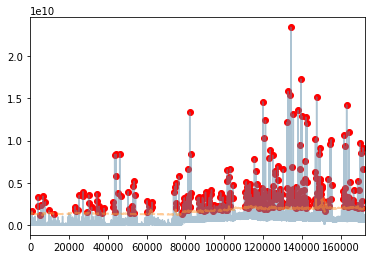

In [ ]:
wadi_se = prep(wadi_pred, wadi_true, 124)
wadi_dspot = dSPOT(1e-4, 100)
wadi_dspot.fit(wadi_se[-n_init:], wadi_se)
wadi_dspot.initialize()
results = wadi_dspot.run()
wadi_dspot.plot(results)

In [ ]:
pd.DataFrame(wadi_se).describe()

,0
count,1.726000e+05
mean,3.610517e+08
std,3.770635e+08
min,8.817233e+06
25%,4.588564e+07
50%,3.969460e+08
75%,5.702327e+08
max,2.343104e+10


In [ ]:
lab = np.where(wadi_se > results)

In [ ]:
results